In [1]:
import os
import json
import pyccl
import scipy
import numpy
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec

In [2]:
# Path
TAG = 'Y10'
LABEL = 'KERNEL'
FOLDER = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/LimberCloud/'

INFO_FOLDER = os.path.join(FOLDER, 'INFO')
DATA_FOLDER = os.path.join(FOLDER, 'DATA', TAG)
PLOT_FOLDER = os.path.join(FOLDER, 'PLOT', LABEL, TAG)

In [3]:
# Cosmology
with open(os.path.join(INFO_FOLDER, 'COSMOLOGY.json'), 'r') as file:
    COSMOLOGY_INFO = json.load(file)

COSMOLOGY = pyccl.Cosmology(
    h=COSMOLOGY_INFO['H'],
    w0=COSMOLOGY_INFO['W0'],
    wa=COSMOLOGY_INFO['WA'], 
    n_s=COSMOLOGY_INFO['NS'], 
    A_s=COSMOLOGY_INFO['AS'],
    m_nu=COSMOLOGY_INFO['M_NU'],  
    Neff=COSMOLOGY_INFO['N_EFF'],
    Omega_b=COSMOLOGY_INFO['OMEGA_B'], 
    Omega_k=COSMOLOGY_INFO['OMEGA_K'], 
    Omega_c=COSMOLOGY_INFO['OMEGA_CDM'], 
    mass_split='single', matter_power_spectrum='halofit', transfer_function='boltzmann_camb',
    extra_parameters={'camb': {'kmax': 50, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

In [4]:
# Kernel
def q_m(chi_data, chi_grid, phi_grid):
    
    bin_size = phi_grid.shape[0]
    data_size = chi_data.shape[0] - 1
    grid_size = chi_grid.shape[0] - 1
    q = numpy.zeros((bin_size, data_size + 1))
    
    for k in range(data_size + 1):
        n = numpy.max(numpy.where(chi_grid <= chi_data[k]))
        
        if n < grid_size:
            q[:,k] = (chi_grid[n + 1] - chi_data[k]) / (chi_grid[n + 1] - chi_grid[n]) * phi_grid[:,n] + (chi_data[k] - chi_grid[n]) / (chi_grid[n + 1] - chi_grid[n]) * phi_grid[:,n + 1]
        else:
            q[:,k] = 0.0
    
    return q

In [5]:
# Load in Data
LENS = numpy.load(os.path.join(DATA_FOLDER, 'lsst_lens_bins.npy'), allow_pickle=True).item()

# Size
GRID_SIZE = 350
LENS_BIN_SIZE = len(LENS['bins'])
LENS_REDSHIFT = LENS['redshift_range']

# Grid
Z1 = LENS_REDSHIFT.min()
Z2 = LENS_REDSHIFT.max()
Z_GRID = numpy.linspace(Z1, Z2, GRID_SIZE + 1)

LENS_PSI_GRID = numpy.zeros((LENS_BIN_SIZE, GRID_SIZE + 1))
for BIN_INDEX in range(LENS_BIN_SIZE):
    LENS_PSI_GRID[BIN_INDEX, :] = numpy.interp(x=Z_GRID, xp=LENS_REDSHIFT, fp=LENS['bins'][BIN_INDEX])
LENS_PSI_GRID = LENS_PSI_GRID / scipy.integrate.trapezoid(x=Z_GRID, y=LENS_PSI_GRID, axis=1)[:, numpy.newaxis]

In [6]:
# Comparison
A_GRID = 1 / (1 + Z_GRID)
CHI_GRID = pyccl.background.comoving_radial_distance(cosmo=COSMOLOGY, a=A_GRID)
LENS_PHI_GRID = LENS_PSI_GRID * COSMOLOGY.h_over_h0(a=A_GRID) * COSMOLOGY_INFO['H'] * 100000 / scipy.constants.c

CHI_SIZE = 500
Z_DATA = numpy.linspace(Z1, Z2, CHI_SIZE + 1)

A_DATA = 1 / (1 + Z_DATA)
CHI_DATA = pyccl.background.comoving_radial_distance(cosmo=COSMOLOGY, a=A_DATA)

KERNEL_CCL = numpy.zeros((LENS_BIN_SIZE, CHI_SIZE + 1))
for BIN_INDEX in range(LENS_BIN_SIZE):
    TRACER = pyccl.tracers.WeakLensingTracer(cosmo=COSMOLOGY, dndz=[Z_GRID, LENS_PSI_GRID[BIN_INDEX, :]], has_shear=True, ia_bias=None, use_A_ia=False, n_samples=GRID_SIZE + 1)
    KERNEL_CCL[BIN_INDEX, :] = TRACER.get_dndz(Z_DATA) * COSMOLOGY.h_over_h0(a=1 / (1 + Z_DATA)) * COSMOLOGY_INFO['H'] * 100000 / scipy.constants.c

KERNEL_DATA1 = scipy.interpolate.interp1d(CHI_GRID, LENS_PHI_GRID, kind='slinear')(CHI_DATA)
KERNEL_DATA2 = scipy.interpolate.interp1d(CHI_GRID, LENS_PHI_GRID, kind='quadratic')(CHI_DATA)
KERNEL_DATA3 = scipy.interpolate.interp1d(CHI_GRID, LENS_PHI_GRID, kind='cubic')(CHI_DATA)
KERNEL_DATA = q_m(chi_data=CHI_DATA, chi_grid=CHI_GRID, phi_grid=LENS_PHI_GRID)

KERNEL_RATIO = numpy.divide(KERNEL_DATA, KERNEL_CCL, out=numpy.ones(KERNEL_CCL.shape), where=KERNEL_CCL > 0)
KERNEL_RATIO1 = numpy.divide(KERNEL_DATA1, KERNEL_CCL, out=numpy.ones(KERNEL_CCL.shape), where=KERNEL_CCL > 0)
KERNEL_RATIO2 = numpy.divide(KERNEL_DATA2, KERNEL_CCL, out=numpy.ones(KERNEL_CCL.shape), where=KERNEL_CCL > 0)
KERNEL_RATIO3 = numpy.divide(KERNEL_DATA3, KERNEL_CCL, out=numpy.ones(KERNEL_CCL.shape), where=KERNEL_CCL > 0)

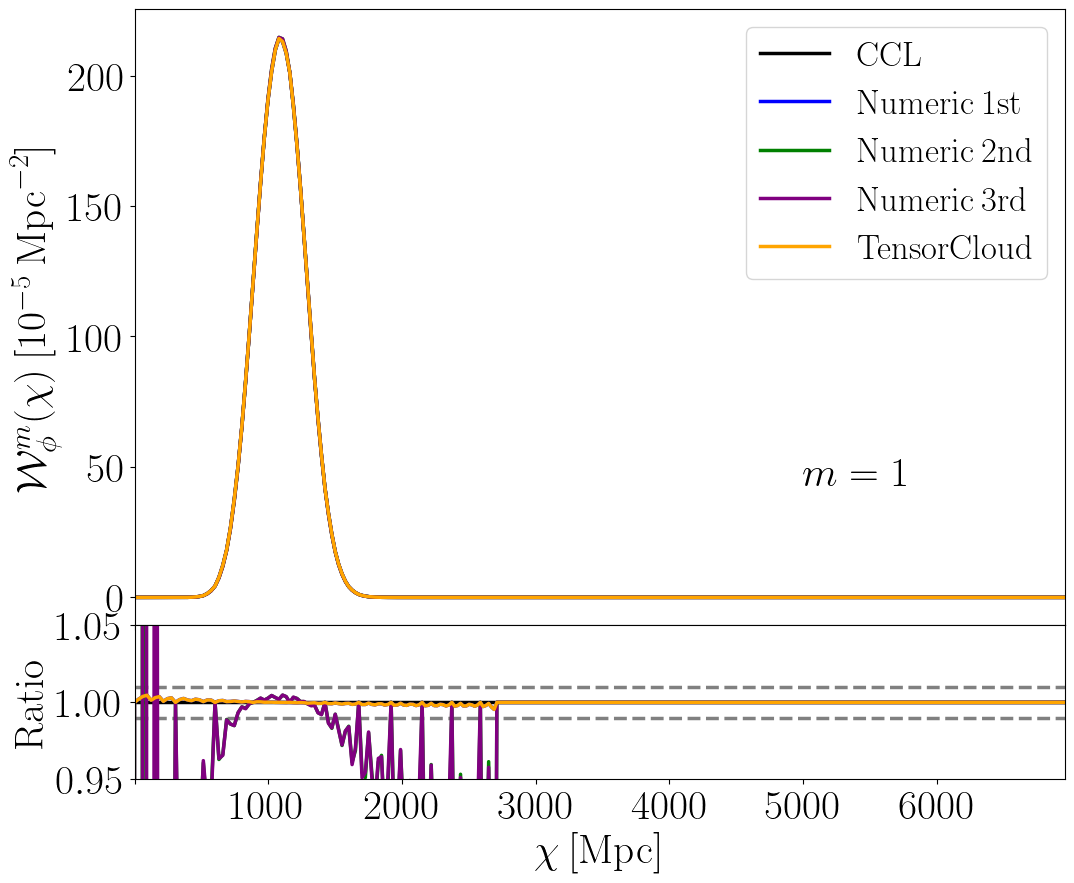

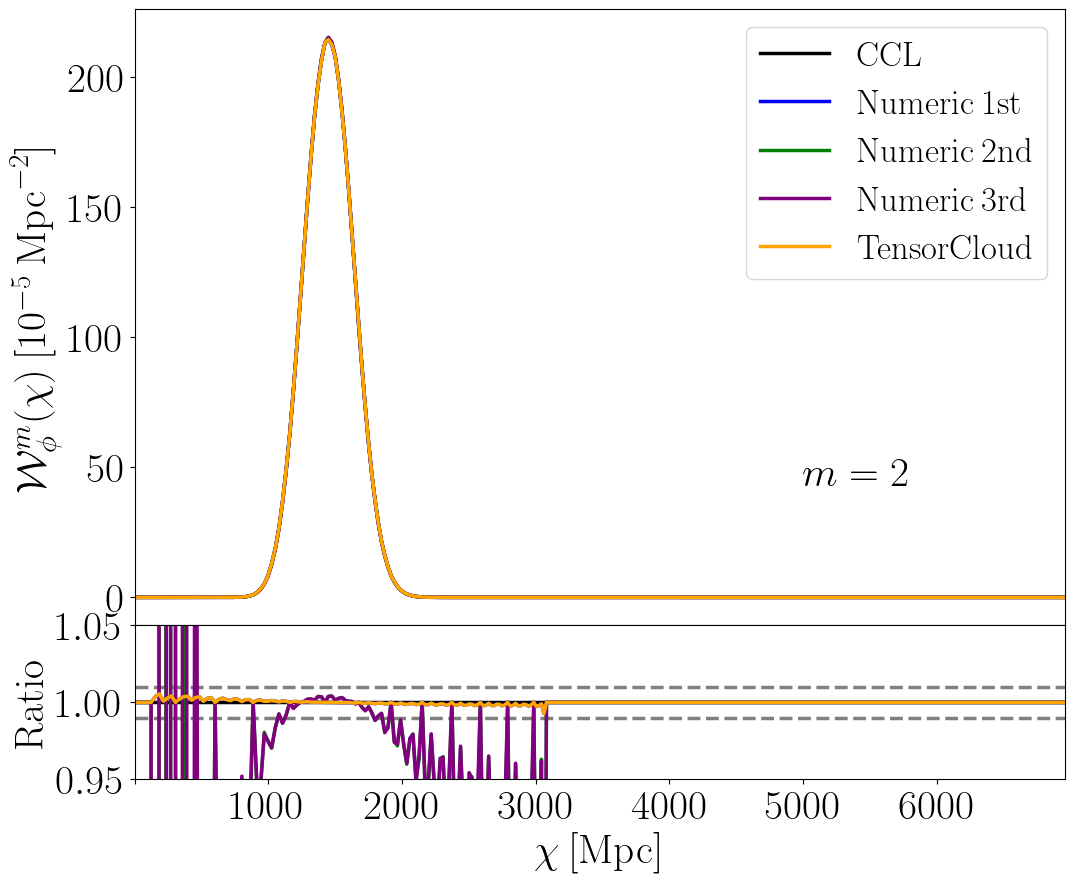

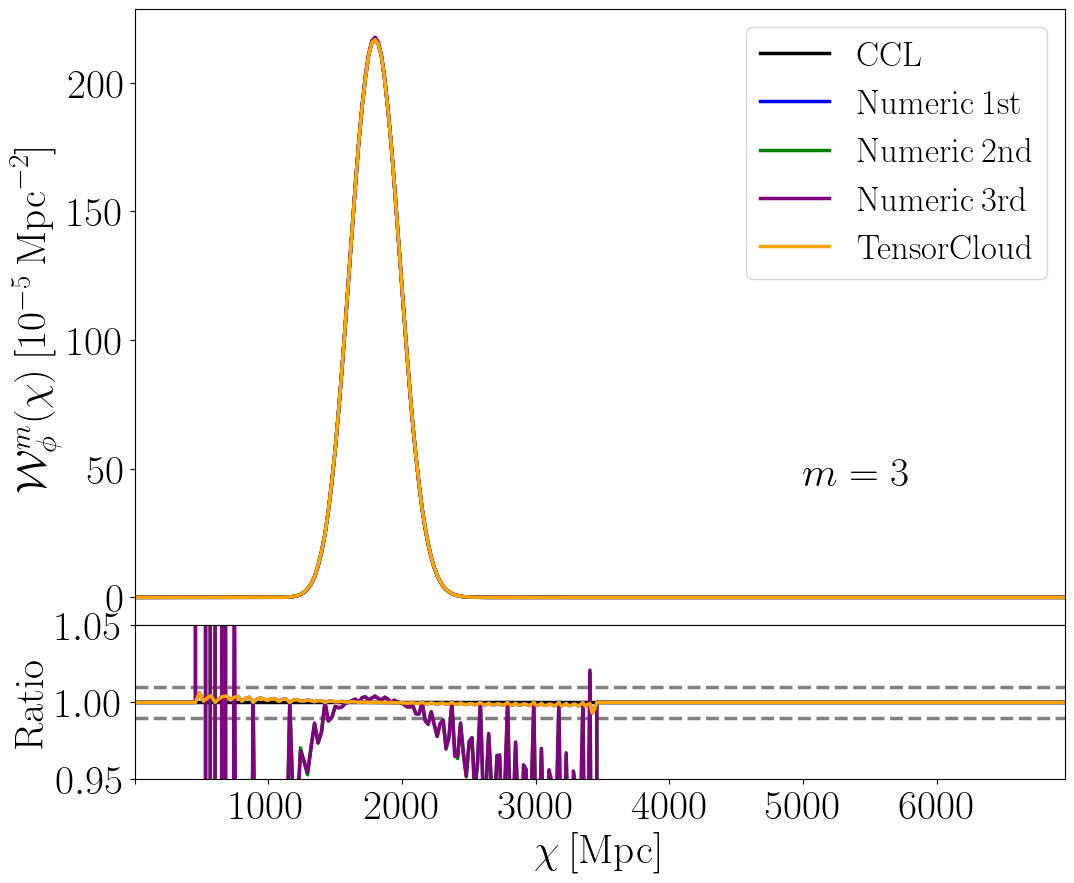

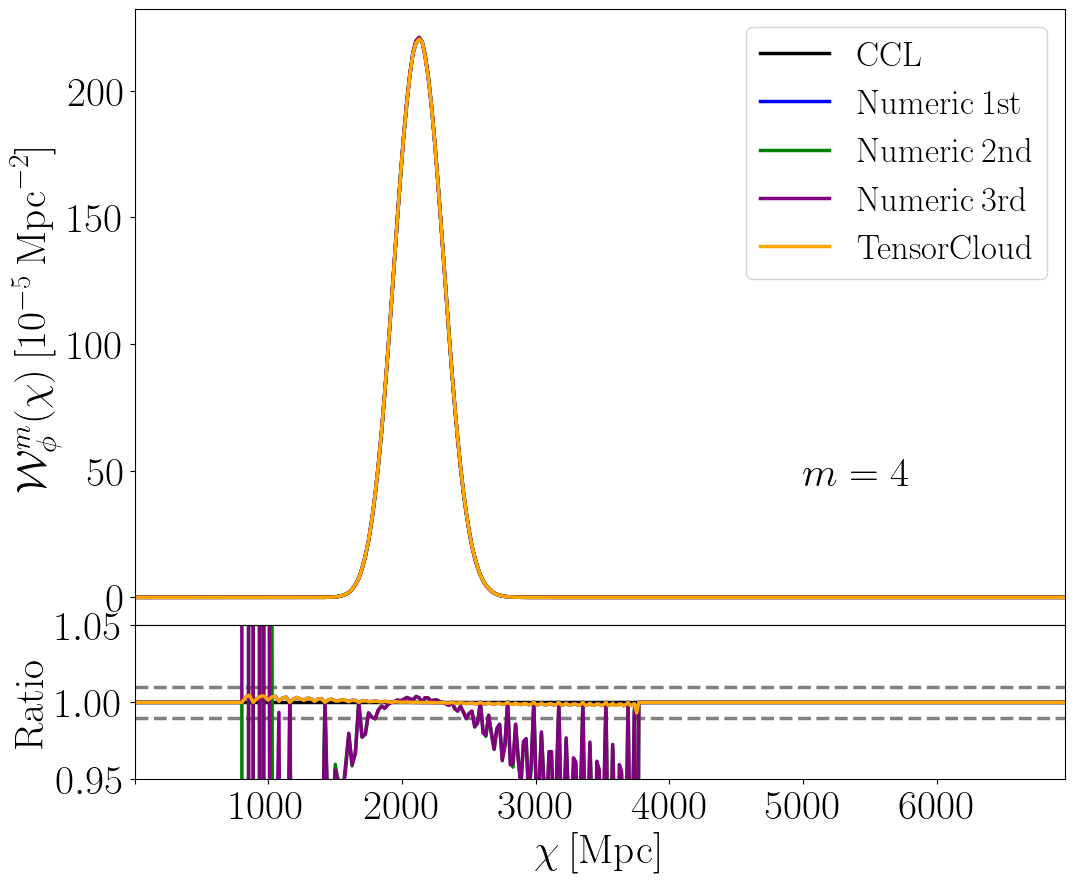

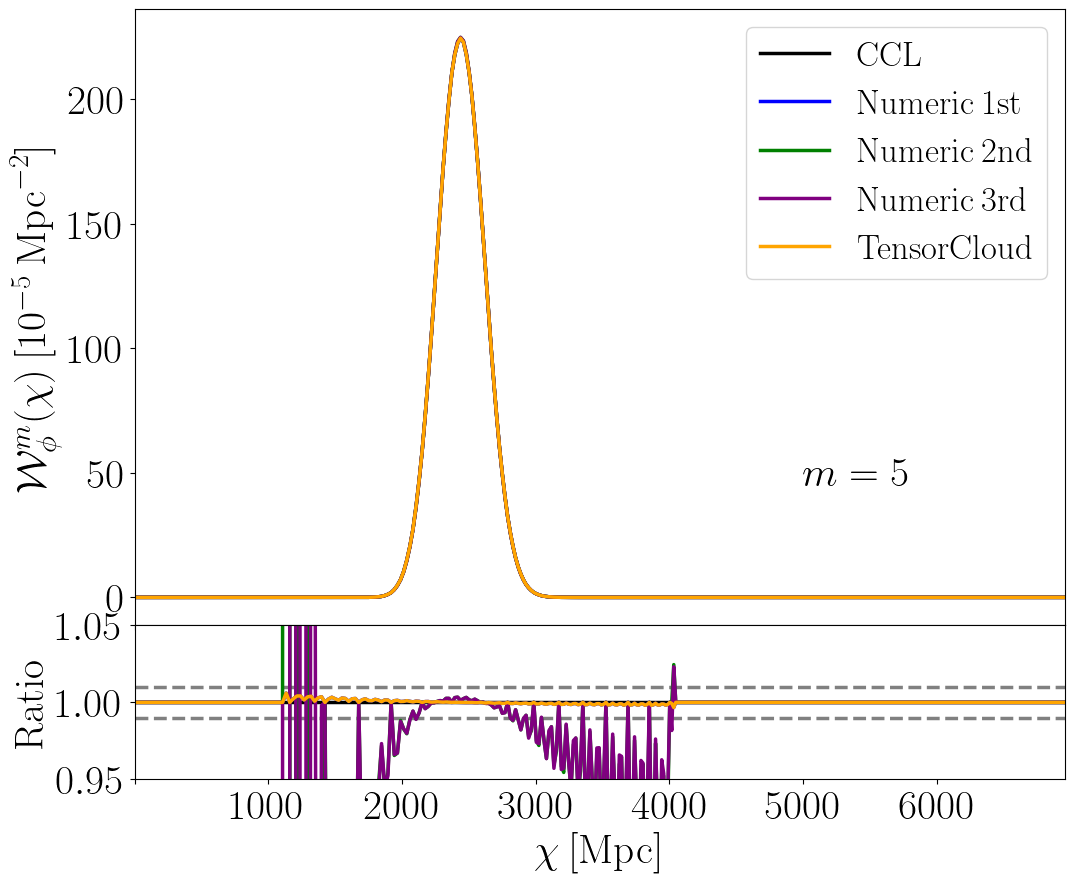

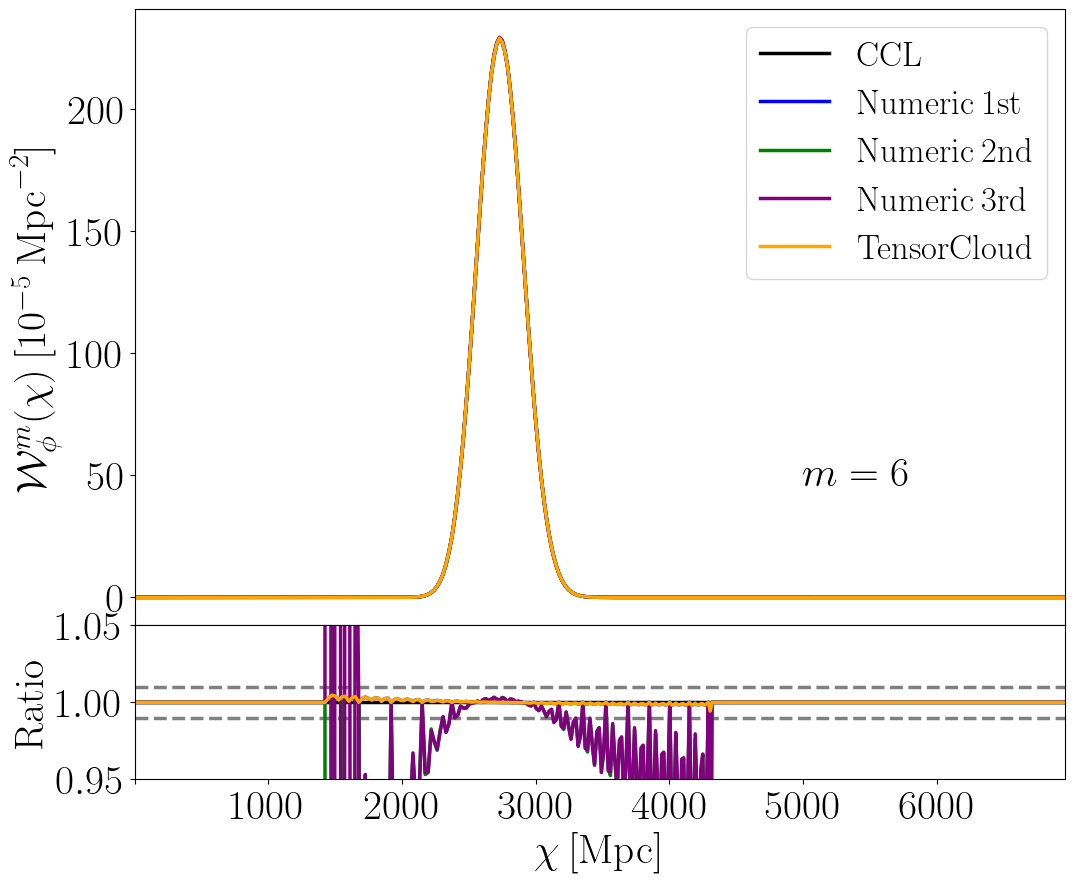

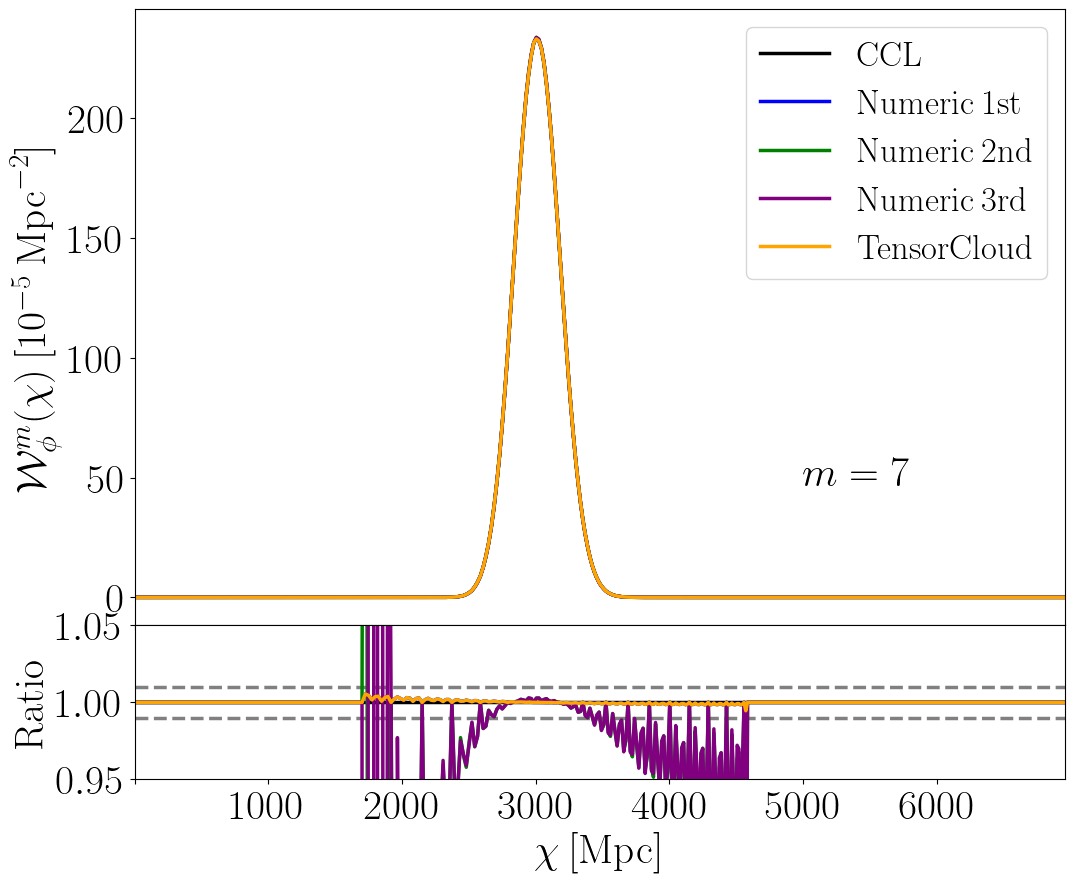

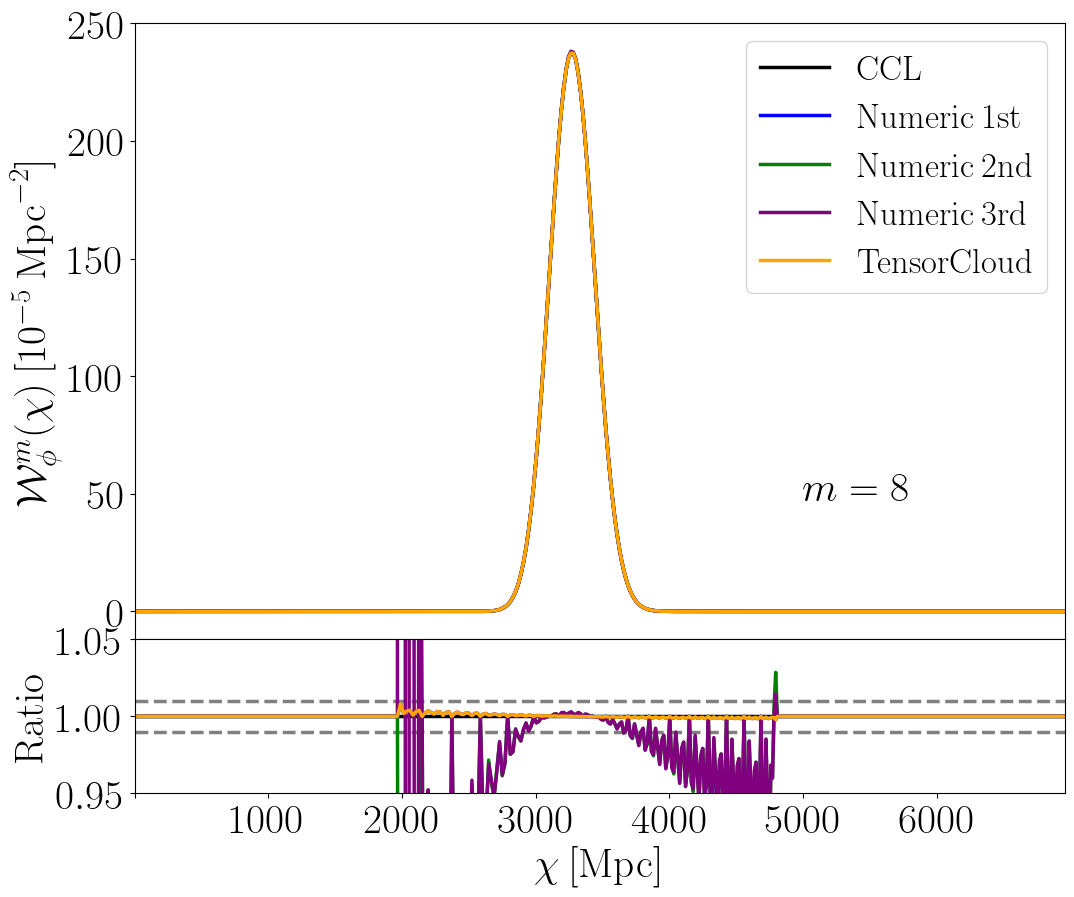

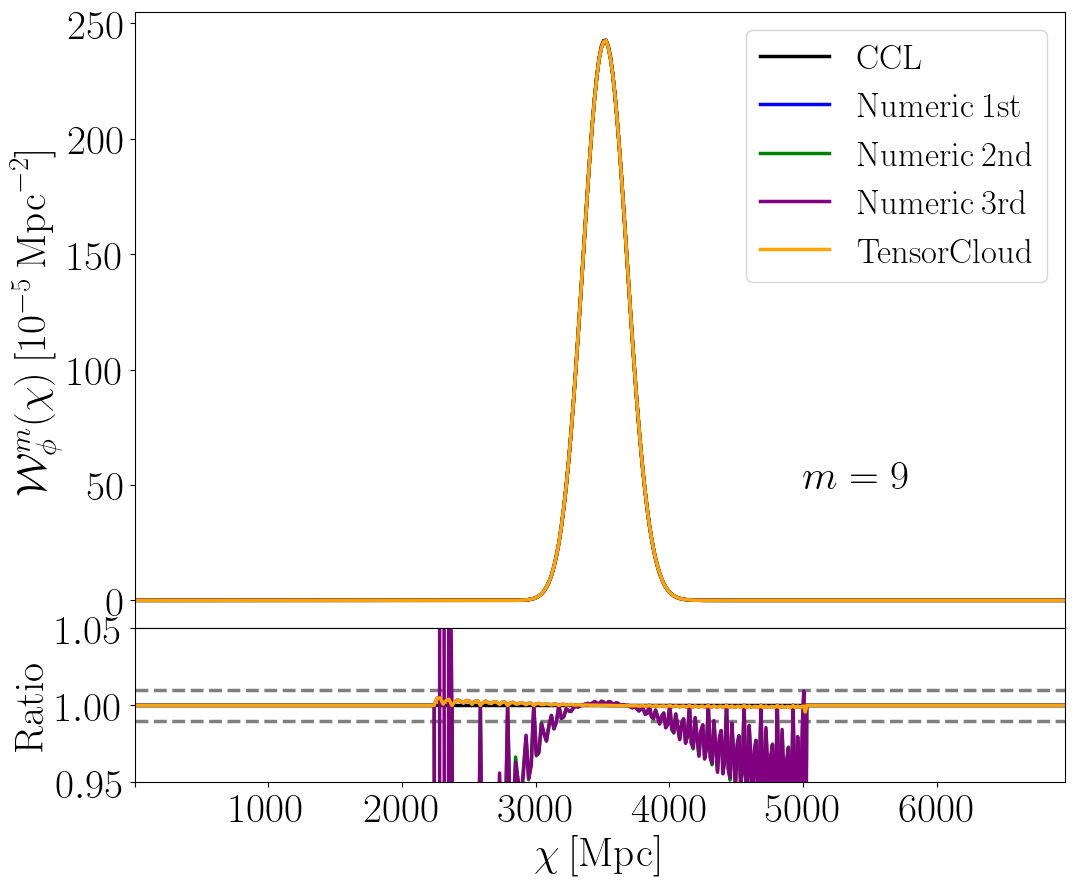

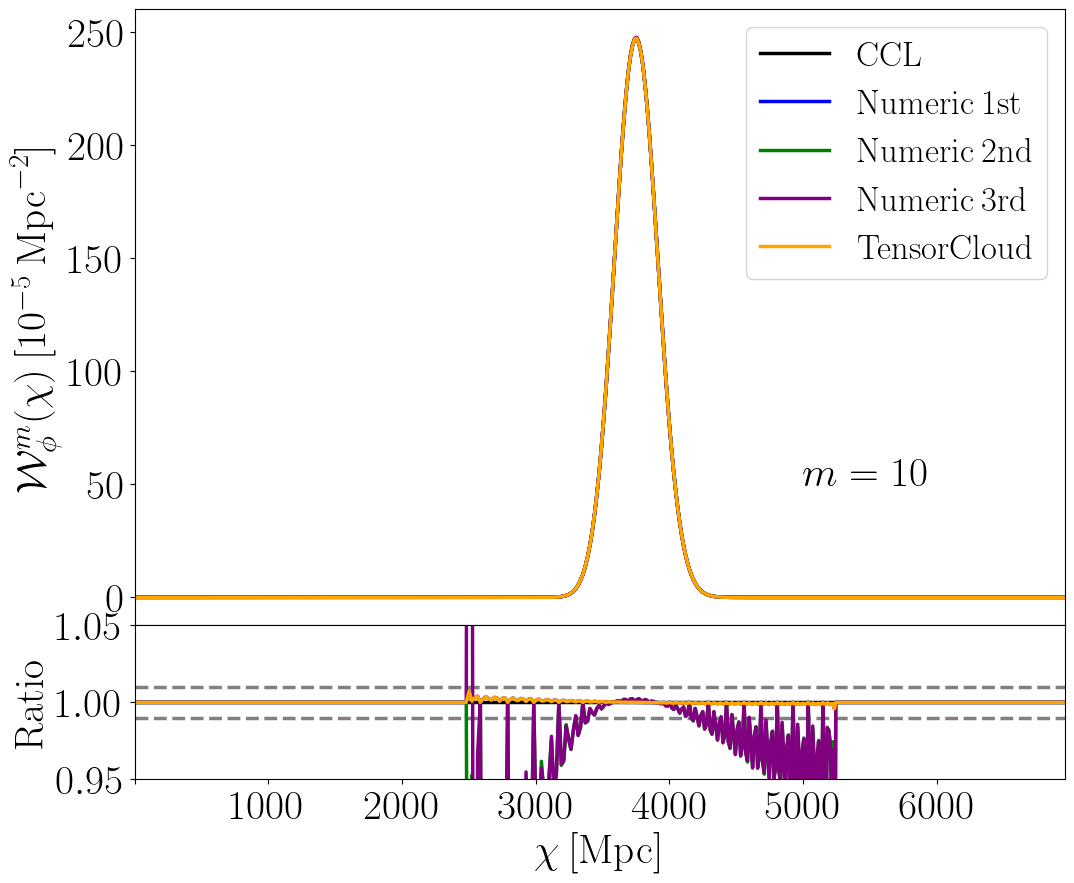

In [7]:
os.environ['PATH'] = '/pscratch/sd/y/yhzhang/texlive/2025/bin/x86_64-linux:' + os.environ['PATH']
pyplot.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
pyplot.rcParams['pgf.texsystem'] = 'pdflatex'
pyplot.rcParams['text.usetex'] = True
pyplot.rcParams['font.size'] = 30
KERNEL0 = 1e-5

for BIN_INDEX in range(LENS_BIN_SIZE):    
    FIGURE = pyplot.figure(figsize=(12, 10))
    GRIDSPEC = GridSpec(10, 12, figure=FIGURE, wspace=0.0, hspace=0.0)
    
    PLOT = FIGURE.add_subplot(GRIDSPEC[0:8, :])
    
    PLOT.plot(CHI_DATA, KERNEL_CCL[BIN_INDEX, :] / KERNEL0, color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$')
    
    PLOT.plot(CHI_DATA, KERNEL_DATA1[BIN_INDEX, :] / KERNEL0, color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$')
    
    PLOT.plot(CHI_DATA, KERNEL_DATA2[BIN_INDEX, :] / KERNEL0, color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$')
    
    PLOT.plot(CHI_DATA, KERNEL_DATA3[BIN_INDEX, :] / KERNEL0, color='purple', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
    
    PLOT.plot(CHI_DATA, KERNEL_DATA[BIN_INDEX, :] / KERNEL0, color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{TensorCloud}$')
    
    PLOT.text(x=5000, y=KERNEL_CCL[BIN_INDEX, :].max() / KERNEL0 / 5, s=r'$m={:.0f}$'.format(BIN_INDEX + 1), fontsize=30)
    
    PLOT.set_xlim(CHI_DATA.min(), CHI_DATA.max())
    PLOT.legend(loc='upper right', fontsize=25)
    
    PLOT.set_xticklabels([])
    PLOT.get_yticklabels()[0].set_visible([])
    PLOT.set_ylabel(r'$\mathcal{W}_\phi^m (\chi) \: [10^{-5} \: \mathrm{Mpc}^{-2}]$')
    
    PLOT = FIGURE.add_subplot(GRIDSPEC[8:, :])
    
    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1), color='black', linestyle='-', linewidth=2.5)
    
    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 + 0.01), color='grey', linestyle='--', linewidth=2.5)
    
    PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 - 0.01), color='grey', linestyle='--', linewidth=2.5)
    
    PLOT.plot(CHI_DATA, KERNEL_RATIO1[BIN_INDEX, :], color='blue', linestyle='-', linewidth=2.5)
    
    PLOT.plot(CHI_DATA, KERNEL_RATIO2[BIN_INDEX, :], color='green', linestyle='-', linewidth=2.5)
    
    PLOT.plot(CHI_DATA, KERNEL_RATIO3[BIN_INDEX, :], color='purple', linestyle='-', linewidth=2.5)
    
    PLOT.plot(CHI_DATA, KERNEL_RATIO[BIN_INDEX, :], color='orange', linestyle='-', linewidth=2.5)
    
    PLOT.set_xlim(CHI_DATA.min(), CHI_DATA.max())
    PLOT.set_ylim(1.00 - 0.05, 1.00 + 0.05)
    PLOT.get_xticklabels()[0].set_visible([])
    
    PLOT.set_xlabel(r'$\chi \: [\mathrm{Mpc}]$')
    PLOT.set_ylabel(r'$\mathrm{Ratio}$')
    
    FIGURE.subplots_adjust(hspace=0.0, wspace=0.0)
    FIGURE.savefig(os.path.join(PLOT_FOLDER, 'PHI{}.pdf'.format(BIN_INDEX + 1)), bbox_inches='tight')